
### Zonal stats to summarize carbon stock per MPA

In [1]:
import pandas as pd
import rasterstats as rs
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

sns.set(font_scale=1.3)

In [2]:
mpas = gpd.read_file('../../gis/mpa/bhs_poli_pa_2017_utm_iucn-edits_holesfilled.shp')

In [3]:
mpas = mpas[mpas.ON_WATER == 1]

In [4]:
mpas = gpd.GeoDataFrame(mpas['AREANAM'], crs=mpas.crs, geometry=mpas.geometry)

In [5]:
## add a poly for all the unprotected marine space:
notmpa = gpd.read_file('../shp/unprotected_hull.shp')

In [7]:
notmpa = gpd.GeoDataFrame(pd.DataFrame(['unprotected'], columns=['AREANAM']), crs=notmpa.crs, geometry=notmpa.geometry)

In [9]:
mpas.geometry.append(notmpa.geometry)


1     POLYGON ((321418.0396696731 2720774.80405705, ...
2     POLYGON ((211723.333663693 2750709.855595818, ...
3     POLYGON ((219750.1620403466 2738449.564293765,...
4     POLYGON ((228473.8345280845 2817029.682598788,...
5     POLYGON ((279399.1131817568 2879920.287602753,...
6     POLYGON ((198508.3415708027 2723821.082453699,...
7     POLYGON ((491006.9999793579 2644064.998475805,...
8     (POLYGON ((415462.8951468131 2599487.582075576...
11    POLYGON ((166843.8113568163 3023584.657100436,...
12    POLYGON ((269239.0882077148 2961954.59777752, ...
16    (POLYGON ((267010.1002582134 2966673.917729765...
18    POLYGON ((270549.4075257382 2962768.90737305, ...
19    POLYGON ((295394.6057673944 2947405.465247697,...
20    POLYGON ((301838.7828904906 2927427.598239705,...
21    POLYGON ((648622.663985322 2335551.858230106, ...
23    POLYGON ((259845.2509643418 2766846.705007225,...
26    POLYGON ((703635.618579624 2369681.870142005, ...
27    POLYGON ((302251.2597582092 2924363.718097

In [10]:
mpas = mpas.append(notmpa)

In [11]:
mpas.tail()
# mpas.set_value('0', 'AREANAM', 'Unprotected')

,AREANAM,geometry
48,West Coast Dive Site,"POLYGON ((543124.3234947735 2647086.649259881,..."
49,Greens Bay National Park,"POLYGON ((557522.3679434035 2661262.597577541,..."
50,Graham's Harbour,"POLYGON ((555981.1635917079 2667801.554185938,..."
52,Pigeon Creek & Snow Bay National Park,"POLYGON ((554423.1614116175 2655711.532638492,..."
0,unprotected,(POLYGON ((642121.0779999999 2313574.624000001...


In [12]:
stock_stats = rs.zonal_stats(mpas, '../Bahamas_blue_carbon_workspace_3/bhs_stock.tif', 
               prefix='c_', stats='sum', geojson_out=True)

/usr/local/lib/python2.7/dist-packages/rasterstats/main.py:142: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
  with Raster(raster, affine, nodata, band) as rast:
/usr/local/lib/python2.7/dist-packages/rasterstats/io.py:242: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  self.affine = guard_transform(self.src.transform)


In [52]:
mpa_carbon = gpd.GeoDataFrame.from_features(stock_stats)

In [53]:
mpa_carbon['c_area_km2'] = mpa_carbon.c_sum / (mpa_carbon.area/1000000)

In [54]:
stats_sea = rs.zonal_stats(mpas, '../Bahamas_blue_carbon_workspace_3/bhs_clim_seagrass.tif', 
               prefix='hab_', stats='count', geojson_out=True)

In [55]:
mpa_sea = gpd.GeoDataFrame.from_features(stats_sea)

In [56]:
mpa_carbon['seagrass_km2'] = mpa_sea.hab_count*(0.275*0.275) # cell dimensions in km

In [57]:
stats_mang = rs.zonal_stats(mpas, '../Bahamas_blue_carbon_workspace_3/bhs_clim_mangrove.tif', 
               prefix='hab_', stats='count', geojson_out=True)
mpa_mang = gpd.GeoDataFrame.from_features(stats_mang)

In [58]:
mpa_carbon['mangrove_km2'] = mpa_mang.hab_count*(0.275*0.275) # cell dimensions in km

In [59]:
mpa_carbon['1m_tons_c'] = mpa_carbon.c_sum/1000000

In [60]:
mpa_carbon['mil_dol_10_ton'] = (mpa_carbon.c_sum*10)/1000000
mpa_carbon['mil_dol_40_ton'] = (mpa_carbon.c_sum*40)/1000000

In [61]:
mpa_carbon.to_csv('../data/mpa_carbon.csv', index=False)

#### Plots

In [62]:
mpa_carbon = pd.read_csv('../data/mpa_carbon.csv')

In [67]:
mpa_carbon = mpa_carbon[mpa_carbon.AREANAM != 'unprotected']

In [68]:
print('TOTAL MILLIONS TONS CARBON IN MPAS')
sum(mpa_carbon['1m_tons_c'].fillna(0))

TOTAL MILLIONS TONS CARBON IN MPAS


404.14040416235349

In [69]:
print('TOTAL MILLIONS DOLLARS(10/ton) CARBON IN MPAS')
sum(mpa_carbon['mil_dol_10_ton'].fillna(0))

TOTAL MILLIONS DOLLARS(10/ton) CARBON IN MPAS


4041.4040416235348

In [70]:
print('TOTAL MILLIONS DOLLARS(40/ton) CARBON IN MPAS')
sum(mpa_carbon['mil_dol_40_ton'].fillna(0))

TOTAL MILLIONS DOLLARS(40/ton) CARBON IN MPAS


16165.616166494145

In [71]:
print('Westside NP Carbon')
mpa_carbon[mpa_carbon.AREANAM == 'Westside National Park']

Westside NP Carbon


,AREANAM,c_sum,geometry,c_area_km2,seagrass_km2,mangrove_km2,1m_tons_c,mil_dol_10_ton,mil_dol_40_ton
5,Westside National Park,278756608.0,"POLYGON ((198508.3415708027 2723821.082453699,...",53472.212869,1324.79875,1805.0175,278.756608,2787.56608,11150.26432


In [ ]:
# 10$ per ton of CO2 - for barcharts
# and then calc total value for $10 and $40 estimates

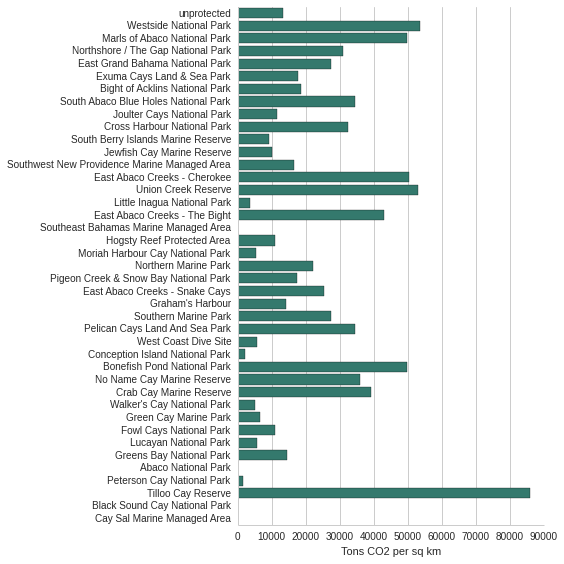

In [67]:
# sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

sns.barplot(y='AREANAM', x='c_area_km2', color='#288574', 
            data=mpa_carbon.sort_values('1m_tons_c', ascending=False))
sns.despine()

ax.set(xlabel='Tons CO2 per sq km', ylabel='')
# ,
#       xlim=(-300, 300))

fig.savefig('../figs/bc_stock_area_bympa.png', dpi=150)
fig.savefig('../figs/bc_stock_area_bympa.svg')

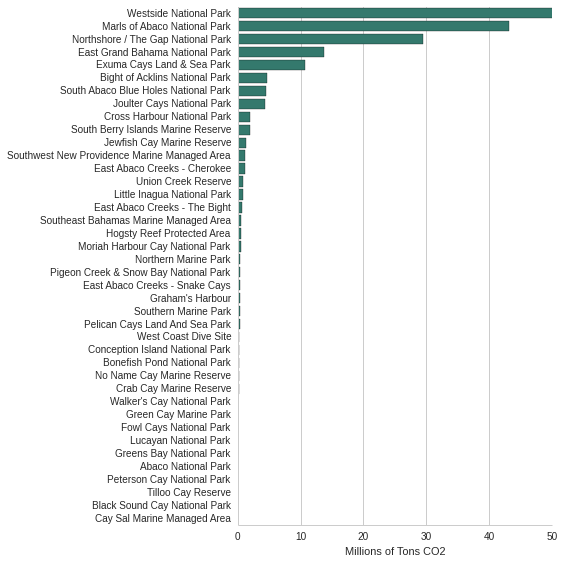

In [68]:
# sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)

sns.barplot(y='AREANAM', x='1m_tons_c', color='#288574', 
            data=mpa_carbon[mpa_carbon.AREANAM != 'unprotected'].sort_values('1m_tons_c', ascending=False))
sns.despine()

ax.set(xlabel='Millions of Tons CO2', ylabel='' ,xlim=(0, 50))

fig.savefig('../figs/bc_stock_sum_bympa.png', dpi=150)
fig.savefig('../figs/bc_stock_sum_bympa.svg')

In [26]:
long_df = pd.melt(frame=mpa_carbon[['AREANAM', 'seagrass_km2', 'mangrove_km2']], id_vars='AREANAM')
# longdf = pd.melt(frame=pts_in_region.drop(axis=1, labels='habrole'), id_vars=['geometry', 'fid', 'Name'])

In [27]:
long_df.sort_values('value').head(40)

,AREANAM,variable,value
79,Graham's Harbour,mangrove_km2,0.000000
42,Northern Marine Park,mangrove_km2,0.000000
43,Southern Marine Park,mangrove_km2,0.000000
47,Conception Island National Park,mangrove_km2,0.000000
49,Walker's Cay National Park,mangrove_km2,0.000000
50,Black Sound Cay National Park,mangrove_km2,0.000000
51,Crab Cay Marine Reserve,mangrove_km2,0.000000
53,Fowl Cays National Park,mangrove_km2,0.000000
22,Cay Sal Marine Managed Area,seagrass_km2,0.000000
54,Tilloo Cay Reserve,mangrove_km2,0.000000


In [28]:
toplot = long_df[long_df.value > 10]

/usr/lib/pymodules/python2.7/matplotlib/figure.py:1595: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


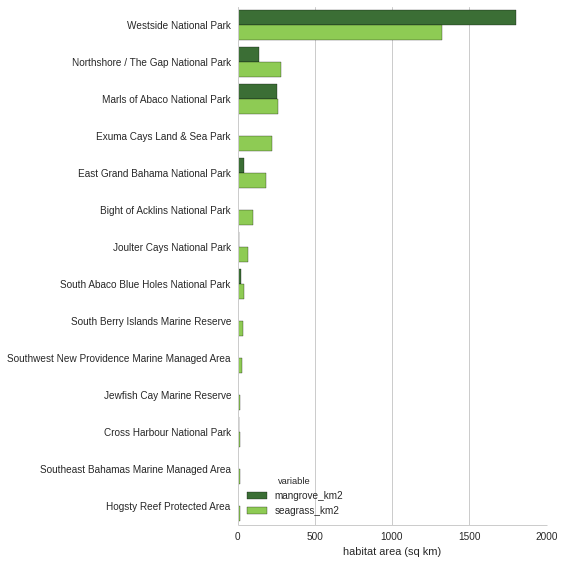

In [30]:
# sns.set_style('whitegrid')
sns.set_context('notebook')
sns.set_style('whitegrid')
fig, ax = plt.subplots()
fig.set_size_inches(8, 8)
cmap = sns.color_palette(['#33782C', '#8DDF40'])

sns.barplot(y='AREANAM', x='value', hue='variable', 
            palette=cmap, hue_order=['mangrove_km2', 'seagrass_km2'],
            data=toplot[toplot.AREANAM != 'unprotected'].sort_values('value', ascending=False))
sns.despine()

ax.set(xlabel='habitat area (sq km)', ylabel='')# ,xlim=(0, 50))

fig.savefig('../figs/bc_stock_habarea_bympa.png', dpi=150)
fig.savefig('../figs/bc_stock_habarea_bympa.svg')